# DATA_MINING01

In [1]:
#Import Bibliotheken
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pprint
from kmodes.kmodes import KModes
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency




# Datei laden, bitte hier manuell abändern
file_path = '/Users/sharu/Documents/DBU/Data Mining 01/DATA_MINING01/input/Spotify_data.xlsx'
df = pd.read_excel(file_path, sheet_name=0)


# Verzeichnis für die Ausgabe der Grafiken erstellen, die ausgeklammert werden kann
'''out_dir = "output"
os.makedirs(out_dir, exist_ok=True)

# plt.show überschreiben, um Grafiken zu speichern
old_show = plt.show

def new_show(*args, **kwargs):
    fig = plt.gcf()
    name = f"plot_{len(os.listdir(out_dir))+1}.png"
    fig.savefig(os.path.join(out_dir, name), dpi=300)
    old_show(*args, **kwargs)

plt.show = new_show

df.head()'''







'out_dir = "output"\nos.makedirs(out_dir, exist_ok=True)\n\n# plt.show überschreiben, um Grafiken zu speichern\nold_show = plt.show\n\ndef new_show(*args, **kwargs):\n    fig = plt.gcf()\n    name = f"plot_{len(os.listdir(out_dir))+1}.png"\n    fig.savefig(os.path.join(out_dir, name), dpi=300)\n    old_show(*args, **kwargs)\n\nplt.show = new_show\n\ndf.head()'

# Data Understanding & Preparation

In [2]:
# Überblick über die Daten
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Age                          520 non-null    object
 1   Gender                       520 non-null    object
 2   spotify_usage_period         520 non-null    object
 3   spotify_listening_device     520 non-null    object
 4   spotify_subscription_plan    520 non-null    object
 5   premium_sub_willingness      520 non-null    object
 6   preffered_premium_plan       312 non-null    object
 7   preferred_listening_content  520 non-null    object
 8   fav_music_genre              520 non-null    object
 9   music_time_slot              520 non-null    object
 10  music_Influencial_mood       520 non-null    object
 11  music_lis_frequency          520 non-null    object
 12  music_expl_method            520 non-null    object
 13  music_recc_rating            520 no

In [3]:
# Fehlende Werte pro Spalte
df.isna().sum()

Age                              0
Gender                           0
spotify_usage_period             0
spotify_listening_device         0
spotify_subscription_plan        0
premium_sub_willingness          0
preffered_premium_plan         208
preferred_listening_content      0
fav_music_genre                  0
music_time_slot                  0
music_Influencial_mood           0
music_lis_frequency              0
music_expl_method                0
music_recc_rating                0
pod_lis_frequency                0
fav_pod_genre                  148
preffered_pod_format           140
pod_host_preference            141
preffered_pod_duration         129
pod_variety_satisfaction         0
dtype: int64

In [4]:
# Duplikate finden
anzahl_duplikate = df.duplicated().sum()

print(anzahl_duplikate)

# Duplikate entfernen
df = df.drop_duplicates().reset_index(drop=True)

1


In [5]:

# Kategorische Variablen analysieren

cat_cols = [
    "spotify_subscription_plan",
    "Gender",
    "Age",
    "fav_music_genre",
    "music_lis_frequency",
    "preffered_premium_plan",
    "pod_lis_frequency",          
    "premium_sub_willingness"     
]
# Analyse der kategorischen Variablen
for c in cat_cols:
    if c in df.columns:
        print(f"\n=== {c} ===")
        counts = df[c].value_counts(dropna=False)
        perc = df[c].value_counts(normalize=True, dropna=False).round(3) * 100
        summary = pd.DataFrame({"count": counts, "percent": perc})
        display(summary)
    else:
        print(f"[Info] Spalte {c} nicht im DataFrame vorhanden")




=== spotify_subscription_plan ===


,count,percent
spotify_subscription_plan,,
Free (ad-supported),423,81.5
Premium (paid subscription),96,18.5



=== Gender ===


,count,percent
Gender,,
Female,390,75.1
Male,114,22.0
Others,15,2.9



=== Age ===


,count,percent
Age,,
20-35,421,81.1
12-20,71,13.7
35-60,23,4.4
6-12,3,0.6
60+,1,0.2



=== fav_music_genre ===


,count,percent
fav_music_genre,,
Melody,258,49.7
classical,87,16.8
Pop,85,16.4
Rap,55,10.6
Electronic/Dance,16,3.1
All,6,1.2
Rock,4,0.8
Kpop,4,0.8
"Classical & melody, dance",2,0.4



=== music_lis_frequency ===


,count,percent
music_lis_frequency,,
While Traveling,111,21.4
leisure time,87,16.8
"While Traveling, leisure time",64,12.3
"While Traveling, Workout session, leisure time",48,9.2
Workout session,33,6.4
Study Hours,19,3.7
Office hours,16,3.1
"While Traveling, Workout session",16,3.1
"Office hours, While Traveling",12,2.3



=== preffered_premium_plan ===


,count,percent
preffered_premium_plan,,
NaN,207,39.9
Individual Plan- Rs 119/ month,95,18.3
Student Plan-Rs 59/month,94,18.1
Duo plan- Rs 149/month,84,16.2
Family Plan-Rs 179/month,39,7.5



=== pod_lis_frequency ===


,count,percent
pod_lis_frequency,,
Rarely,201,38.7
Never,129,24.9
Once a week,91,17.5
Several times a week,78,15.0
Daily,20,3.9



=== premium_sub_willingness ===


,count,percent
premium_sub_willingness,,
No,333,64.2
Yes,186,35.8



Upgrade-Bereitschaft nach Abo-Plan:
premium_sub_willingness       No  Yes  All
spotify_subscription_plan                 
Free (ad-supported)          309  114  423
Premium (paid subscription)   24   72   96
All                          333  186  519


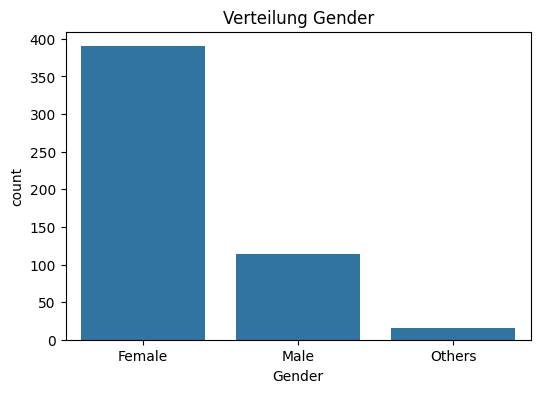

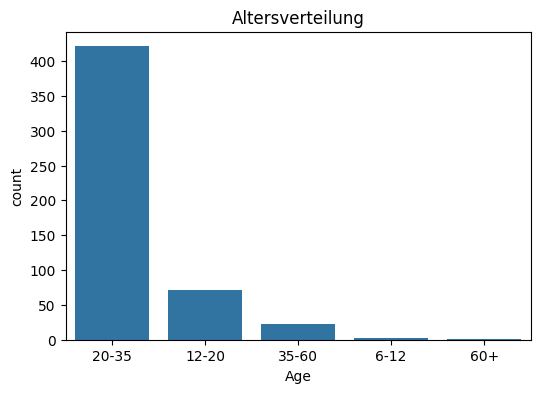

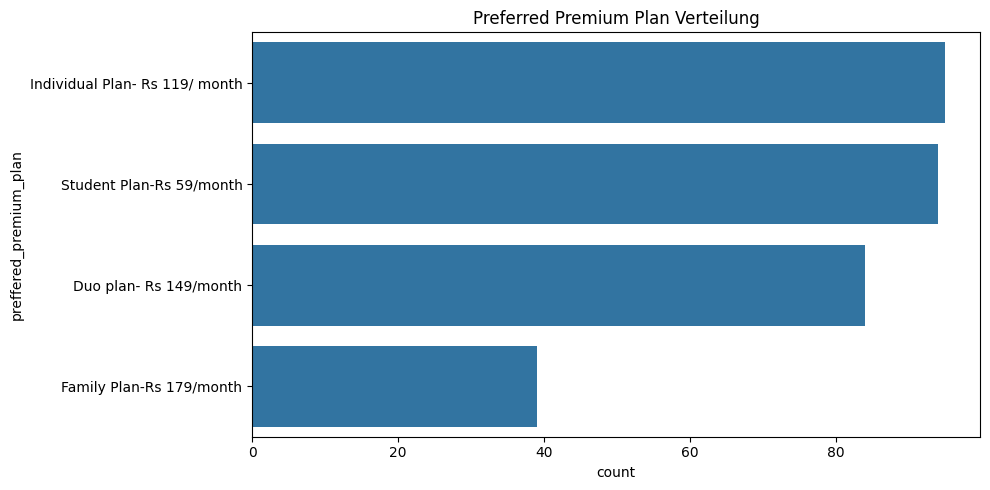

In [6]:
# Kreuztabellen für interessante Kombinationen
if "spotify_subscription_plan" in df.columns and "premium_sub_willingness" in df.columns:
    cross = pd.crosstab(df["spotify_subscription_plan"], df["premium_sub_willingness"], margins=True)
    print("\nUpgrade-Bereitschaft nach Abo-Plan:")
    print(cross)

# Visualisierung der Verteilung von "Gender"
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Gender')
plt.title('Verteilung Gender')
plt.show()

# Visualisierung der Verteilung von "Age"
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Age', order=df['Age'].value_counts().index)
plt.title('Altersverteilung')
plt.show()

# Visualisierung der Verteilung von "fav_music_genre"
plt.figure(figsize=(10,5))
sns.countplot(data=df, y='preffered_premium_plan', order=df['preffered_premium_plan'].value_counts().index)
plt.title('Preferred Premium Plan Verteilung')
plt.tight_layout()
plt.show()

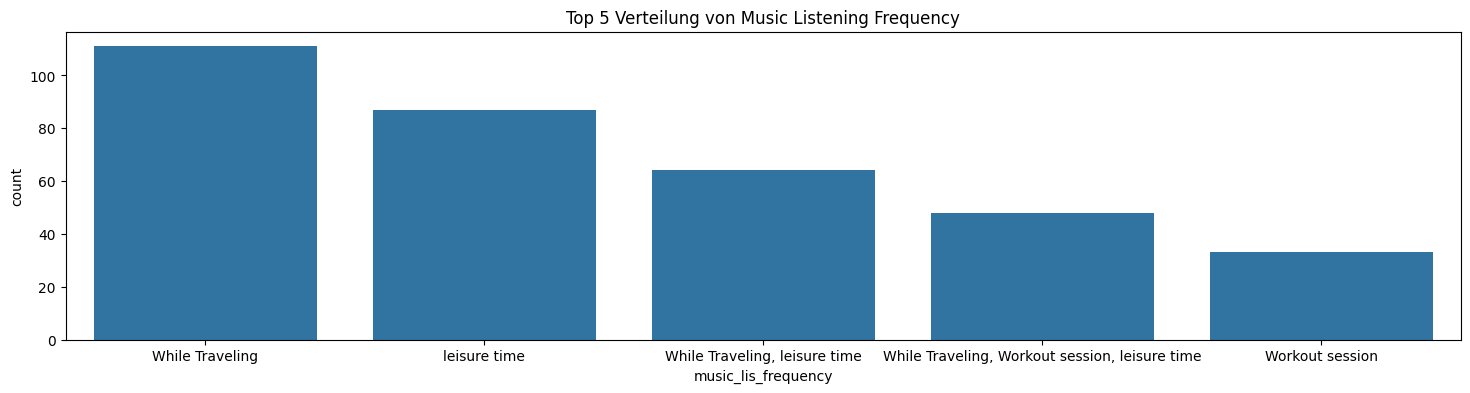

In [7]:
# Top 5 Werte in music_lis_frequency bestimmen
top5_freq = df['music_lis_frequency'].value_counts().nlargest(5).index

# Filter DataFrame auf Top 5 Einträge
df_top5 = df[df['music_lis_frequency'].isin(top5_freq)]

# Balkendiagramm erstellen

plt.figure(figsize=(18,4))
sns.countplot(data=df_top5, x='music_lis_frequency', order=top5_freq)
plt.title('Top 5 Verteilung von Music Listening Frequency')
plt.show()


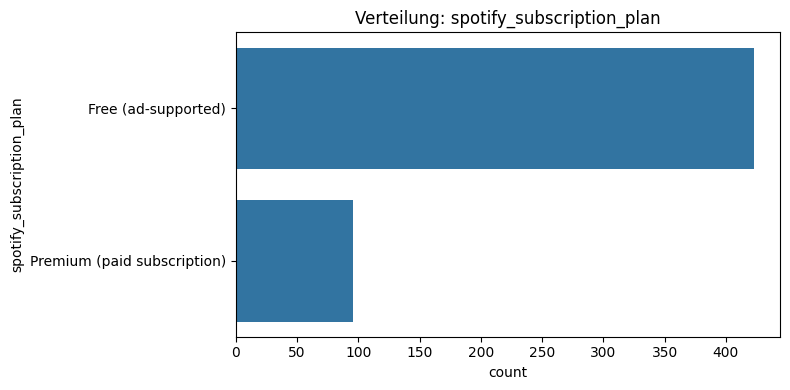

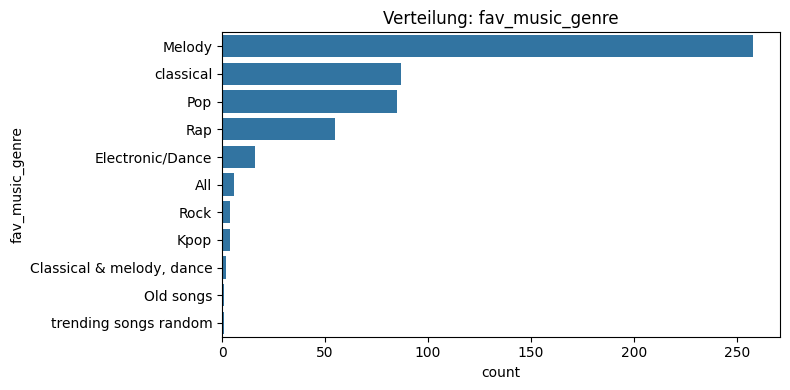

/var/folders/ws/9ktx56mn33q5gm772nl7z7lw0000gn/T/ipykernel_54804/2760551367.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


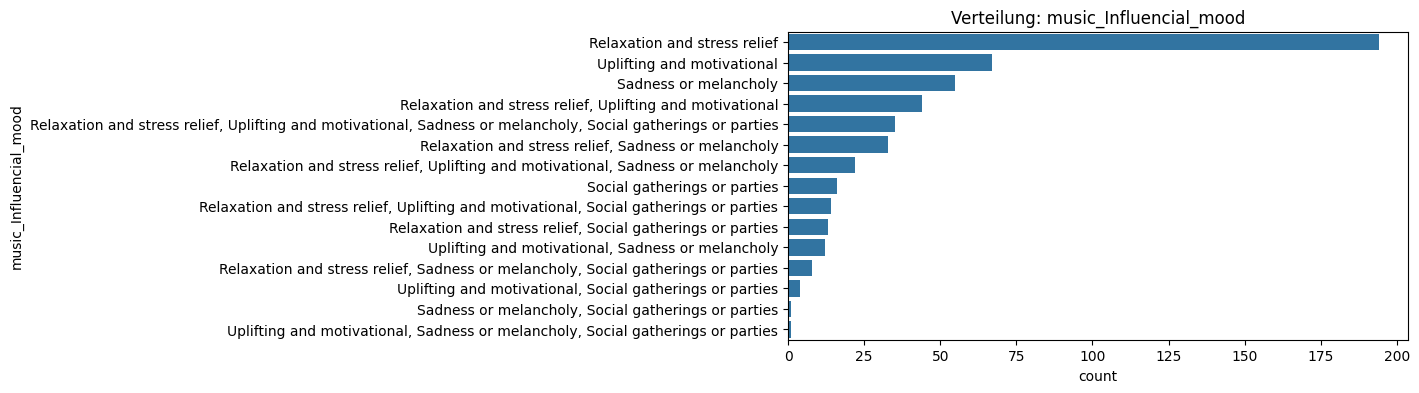

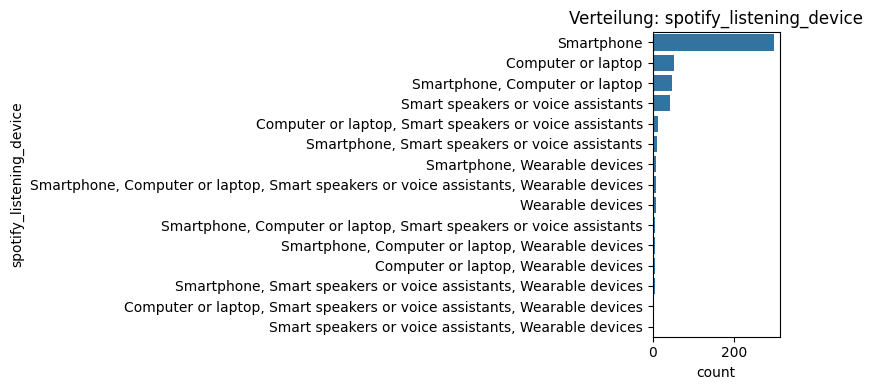

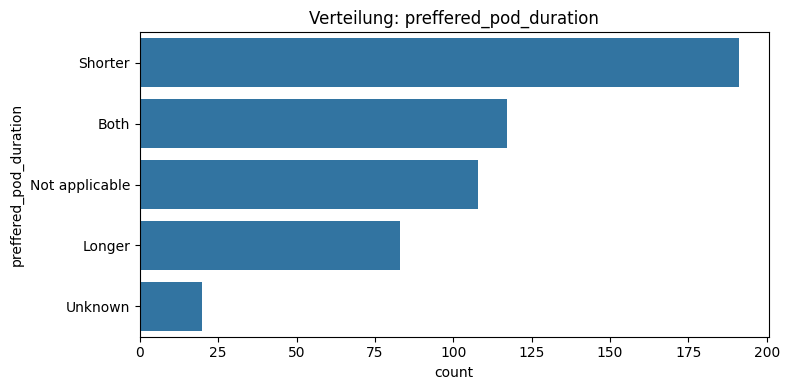

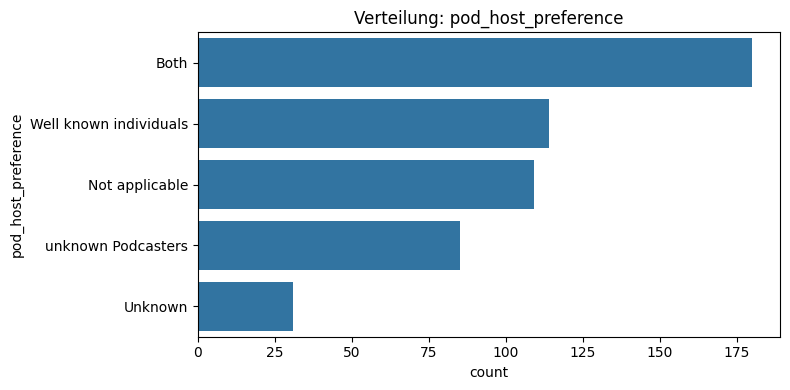

In [8]:
# Liste der Podcast-bezogenen Variablen
pod_cols = ["fav_pod_genre", "preffered_pod_format", "pod_host_preference", "preffered_pod_duration"]

# Bedingtes Füllen: wenn Frequency = Never -> "Not applicable"
for c in pod_cols:
    if c in df.columns and "pod_lis_frequency" in df.columns:
        df.loc[df["pod_lis_frequency"].astype(str).str.lower()=="never", c] = df.loc[
            df["pod_lis_frequency"].astype(str).str.lower()=="never", c
        ].fillna("Not applicable")

# Danach die restlichen NaNs wie bisher durch "Unknown" ersetzen
cat_missing_cols = ["preffered_premium_plan"] + pod_cols
for col in cat_missing_cols:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")


# Visualisierung der Verteilung für ausgewählte kategorische Variablen
cat_cols_for_eda = [
    'spotify_subscription_plan',
    'fav_music_genre',
    'music_Influencial_mood',
    'spotify_listening_device',
    'preffered_pod_duration',
    'pod_host_preference'
]

for col in cat_cols_for_eda:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, y=col, order=df[col].value_counts().index)
    plt.title(f'Verteilung: {col}')
    plt.tight_layout()
    plt.show()


In [9]:
# Kreuztabelle als Analysebeispiel
cross_tab = pd.crosstab(df['preffered_pod_duration'], df['pod_host_preference'])
print(cross_tab)

pod_host_preference     Both  Not applicable  Unknown  Well known individuals  \
preffered_pod_duration                                                          
Both                      50               0        5                      25   
Longer                    32               0        0                      16   
Not applicable             1             106        0                       1   
Shorter                   96               3        7                      72   
Unknown                    1               0       19                       0   

pod_host_preference     unknown Podcasters  
preffered_pod_duration                      
Both                                    37  
Longer                                  35  
Not applicable                           0  
Shorter                                 13  
Unknown                                  0  


In [10]:
# One-Hot-Encoding spezieller Mehrfachauswahlspalten
multi_choice_cols = ['music_Influencial_mood', 'spotify_listening_device', 'music_expl_method']

for col in multi_choice_cols:
    df[col + '_list'] = df[col].str.split(',')
    df_expanded = df[[col + '_list']].explode(col + '_list')

    dummies = pd.get_dummies(df_expanded[col + '_list'].str.strip())
    dummies = dummies.add_prefix(col + '_')

    dummies_agg = dummies.groupby(df_expanded.index).max()

# Entferne alte Spalten mit denselben Namen, falls vorhanden
    duplicate_cols = [c for c in dummies_agg.columns if c in df.columns]
    if duplicate_cols:
        df = df.drop(columns=duplicate_cols)

    df = pd.concat([df, dummies_agg], axis=1)

In [11]:
# Liste der einfachen kategorialen Spalten
simple_cat_cols = [
    'spotify_subscription_plan',
    'fav_music_genre',
    'preffered_pod_duration',
    'pod_host_preference',
    'preffered_premium_plan',
    'music_lis_frequency'
]

# Label-Encoding sicher durchführen
for col in simple_cat_cols:
    if col in df.columns:
        le = LabelEncoder()
# Fehleinträge auffüllen, Konvertierung zu Strings
        df[col] = df[col].fillna('Unknown')
        df[col + '_enc'] = le.fit_transform(df[col].astype(str))
    else:
        print(f"Spalte '{col}' nicht im DataFrame gefunden und wird daher übersprungen.")

# Multi-Choice-Spalten für One-Hot-Encoding
multi_choice_cols = ['music_Influencial_mood', 'spotify_listening_device', 'music_expl_method']

# Features-Liste initialisieren
features = []

# Nur existierende label-encoded Spalten hinzufügen
features += [col + '_enc' for col in simple_cat_cols if col + '_enc' in df.columns]

# Nur existierende One-Hot-Spalten hinzufügen
for col in multi_choice_cols:
    one_hot_cols = [c for c in df.columns if c.startswith(col + '_')]
    features += one_hot_cols

# Optional numerische Spalte hinzufügen, wenn sie existiert
if 'spotify_usage_period_num' in df.columns:
    features.append('spotify_usage_period_num')

# Kontrolle: Zeige Fehlende Spalten vor dem finalen DataFrame
missing = [col for col in features if col not in df.columns]
if missing:
    print("Warnung, folgende Spalten fehlen und werden übersprungen:", missing)

# Nur existierende Features fürs DataFrame verwenden
features = [col for col in features if col in df.columns]

X = df[features]

print(f'Finales Feature-Set mit {len(features)} Features')
print(X.head())


Finales Feature-Set mit 24 Features
   spotify_subscription_plan_enc  fav_music_genre_enc  \
0                              0                    4   
1                              0                    7   
2                              0                    6   
3                              0                    4   
4                              0                    4   

   preffered_pod_duration_enc  pod_host_preference_enc  \
0                           0                        0   
1                           4                        0   
2                           0                        2   
3                           2                        1   
4                           0                        3   

   preffered_premium_plan_enc  music_lis_frequency_enc  \
0                           1                       34   
1                           2                       32   
2                           3                       19   
3                           4           

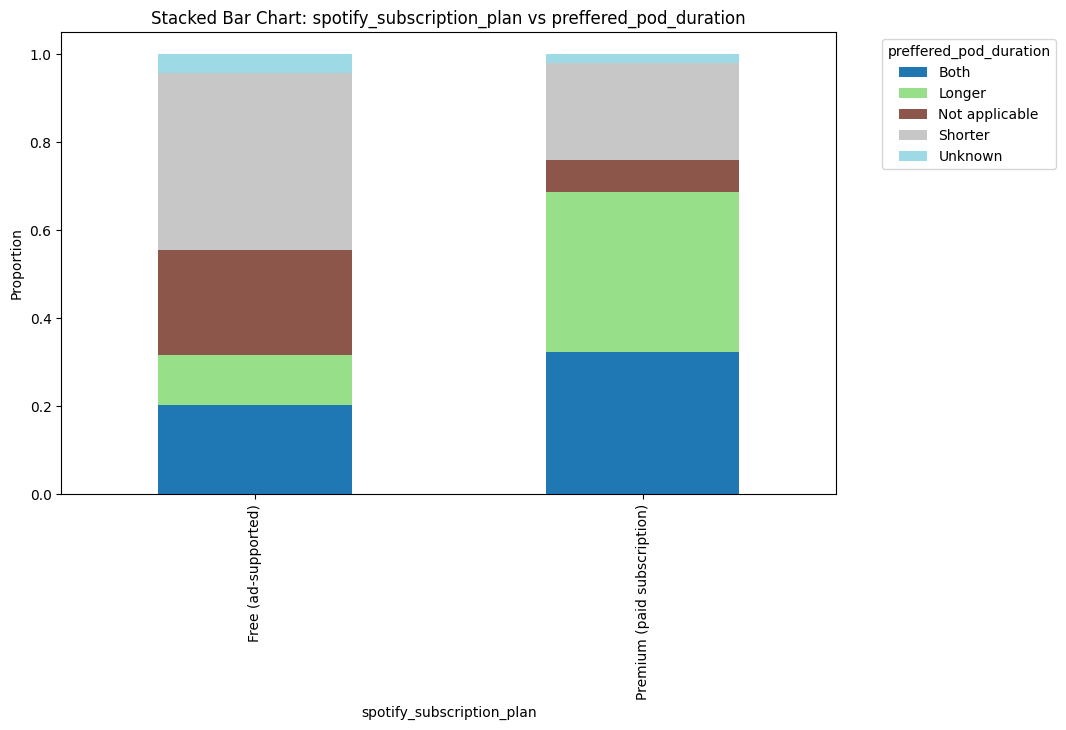

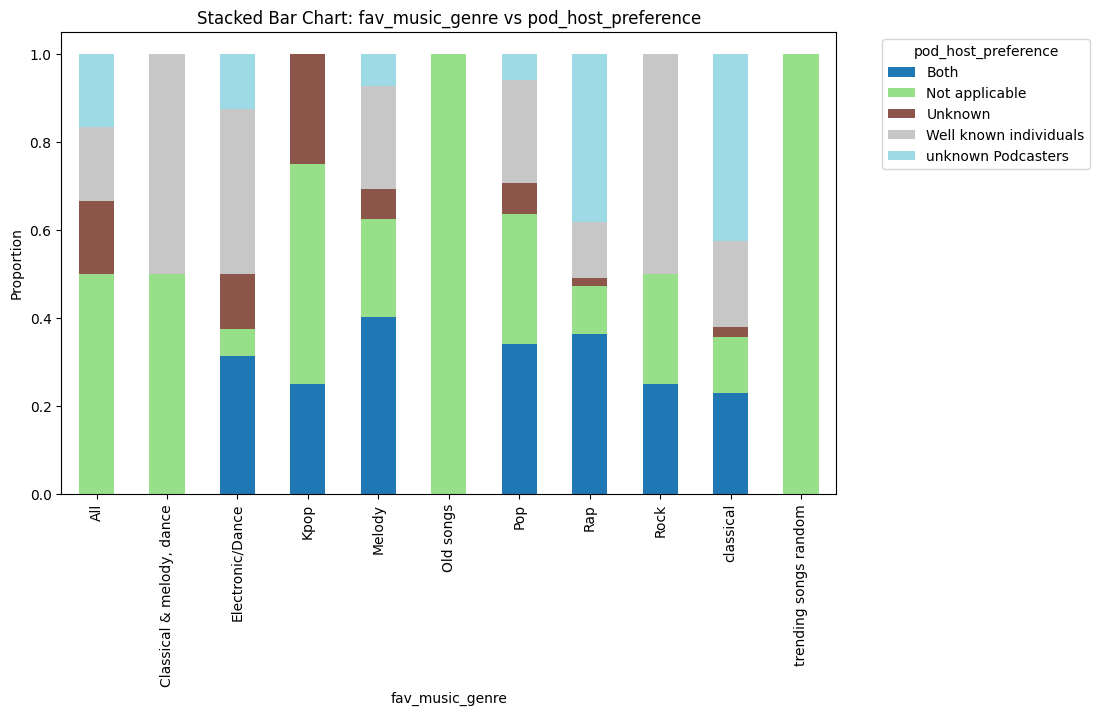

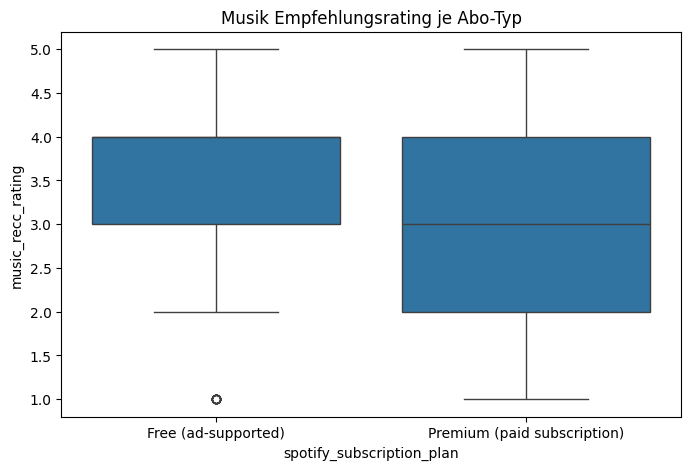

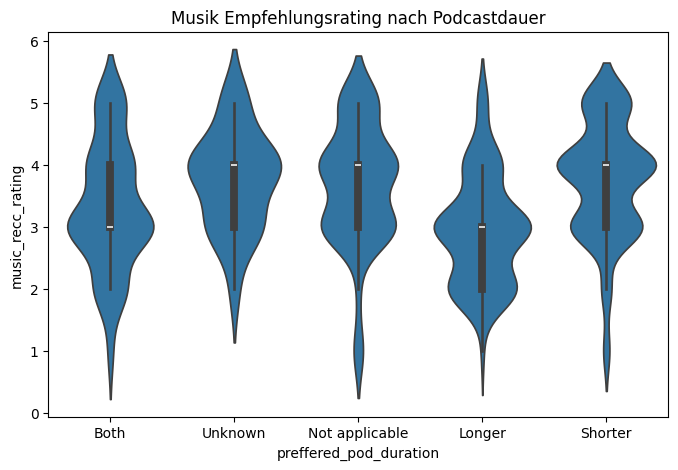

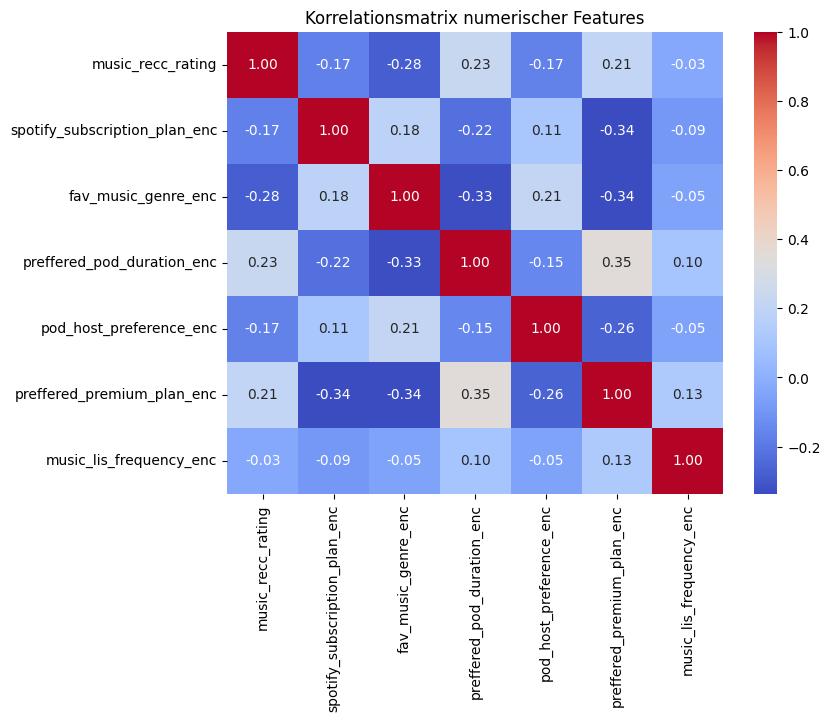

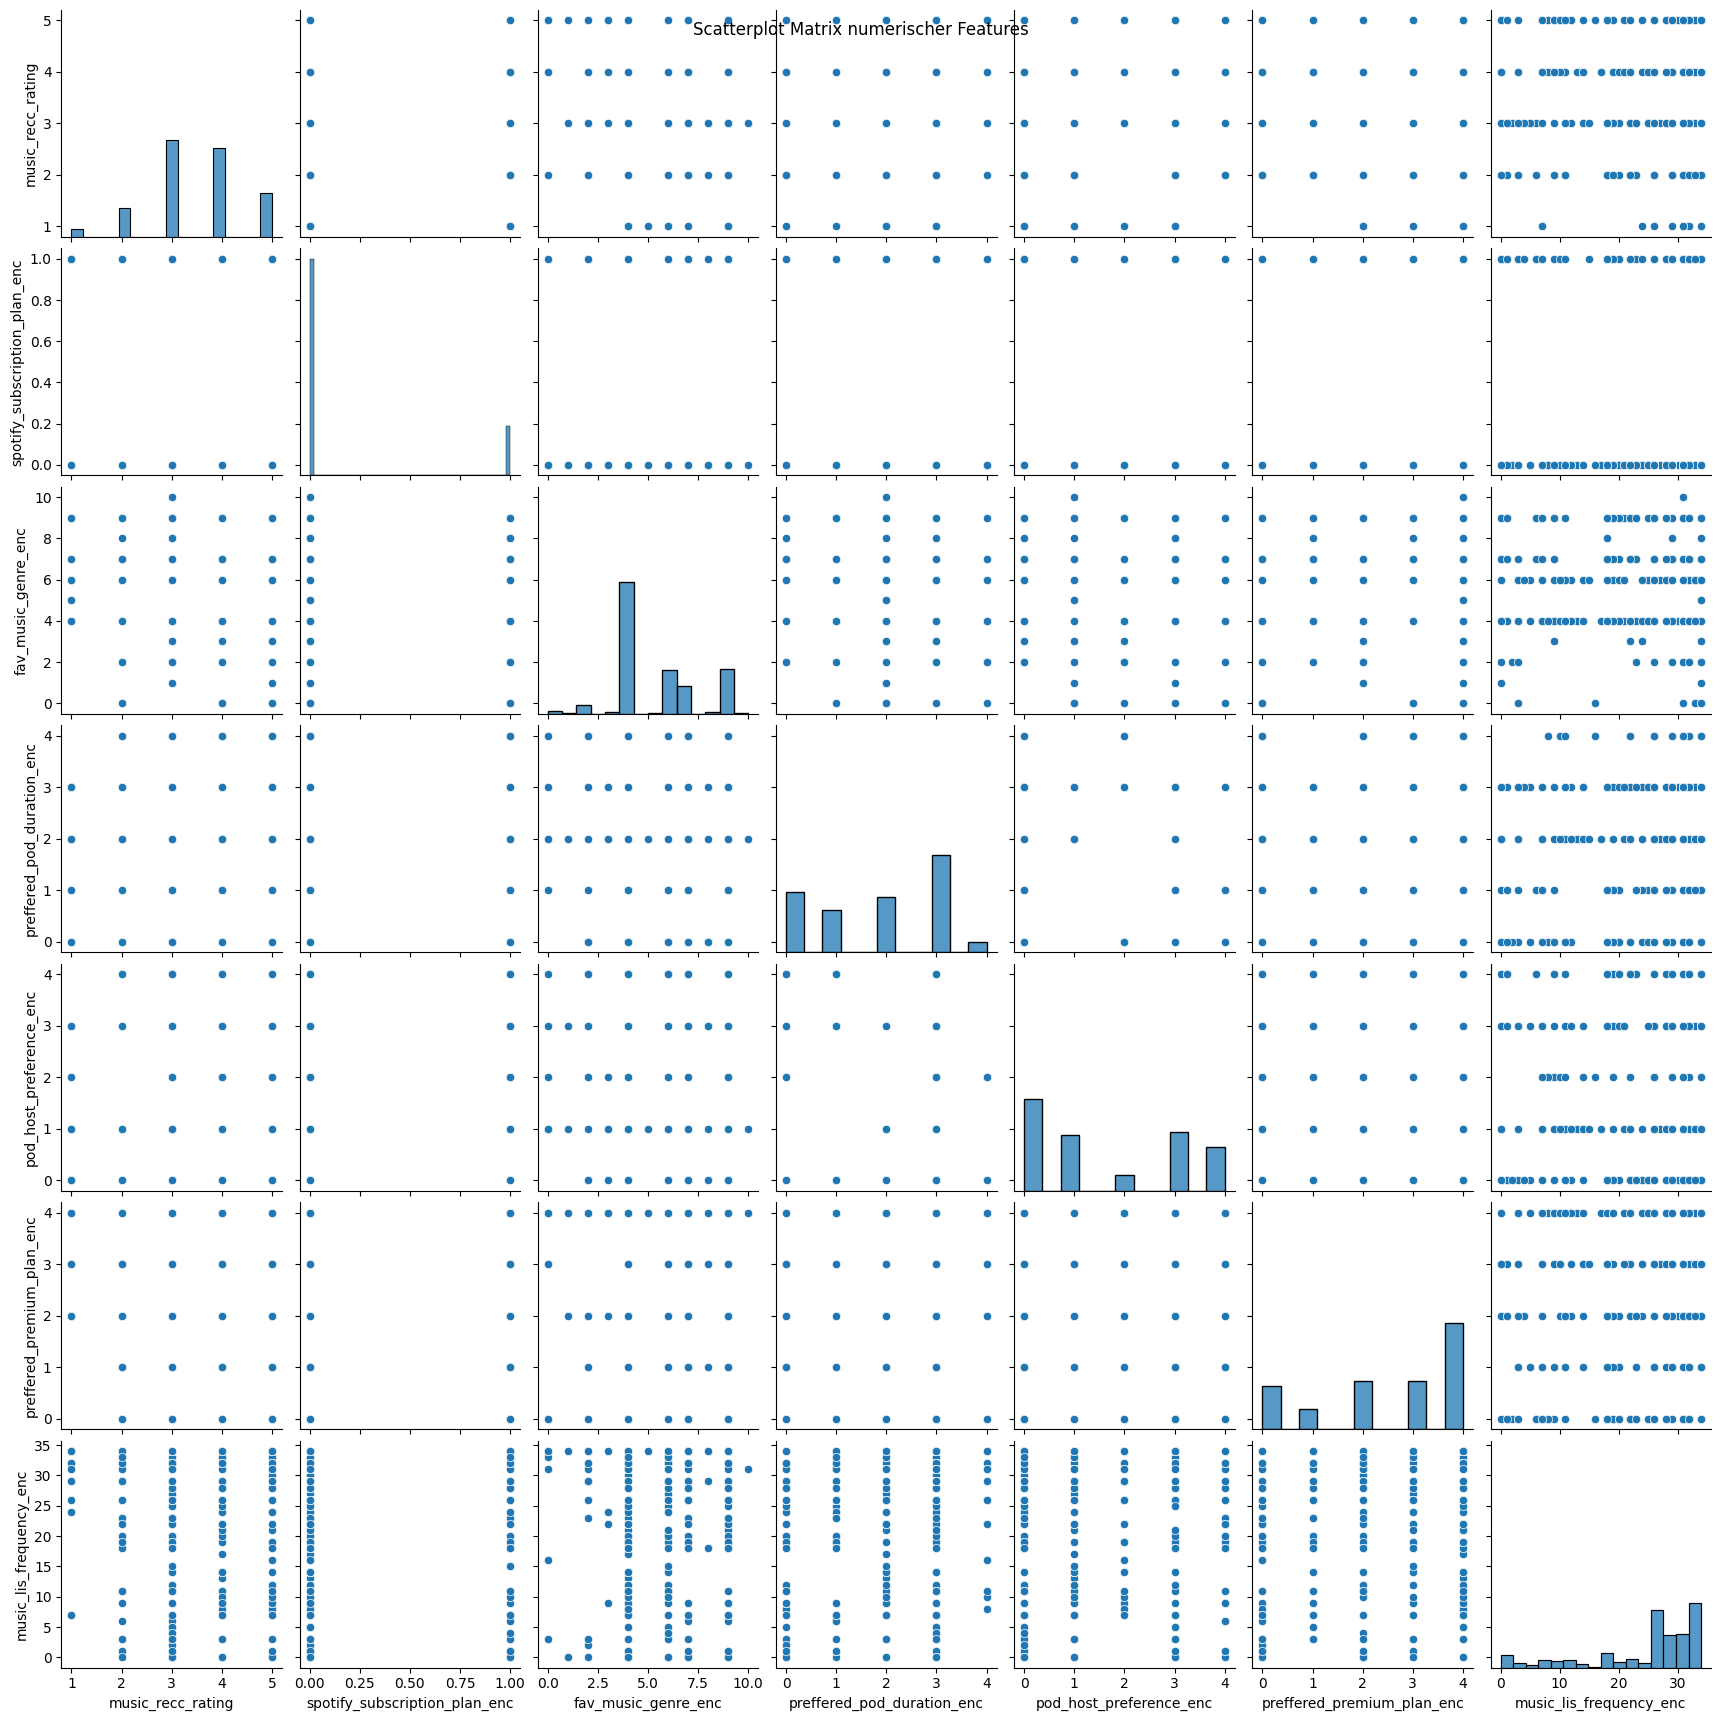

In [12]:


# EDA - Visualisierungen
def plot_stacked_bar(df, feature1, feature2):
    cross_tab = pd.crosstab(df[feature1], df[feature2], normalize='index')
    cross_tab.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
    plt.title(f'Stacked Bar Chart: {feature1} vs {feature2}')
    plt.ylabel('Proportion')
    plt.legend(title=feature2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_stacked_bar(df, 'spotify_subscription_plan', 'preffered_pod_duration')
plot_stacked_bar(df, 'fav_music_genre', 'pod_host_preference')

# Boxplots und Violinplots für Ratings
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='spotify_subscription_plan', y='music_recc_rating')
plt.title('Musik Empfehlungsrating je Abo-Typ')
plt.show()

plt.figure(figsize=(8,5))
sns.violinplot(data=df, x='preffered_pod_duration', y='music_recc_rating')
plt.title('Musik Empfehlungsrating nach Podcastdauer')
plt.show()

# Heatmap Korrelationsmatrix für numerische Features
# Zuerst numerische Spalten auswählen
numerics = df.select_dtypes(include=['int64', 'float64']).columns
if len(numerics) > 1:
    plt.figure(figsize=(8,6))
    corr = df[numerics].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Korrelationsmatrix numerischer Features')
    plt.show()

# Scatterplot Matrix für wichtige numerische Features
if len(numerics) > 1:
    sns.pairplot(df[numerics])
    plt.suptitle('Scatterplot Matrix numerischer Features')
    plt.show()




In [13]:


# Entferne temporäre Listenspalten aus dem DataFrame
list_cols = [col for col in df.columns if col.endswith('_list')]
df = df.drop(columns=list_cols)

# Label-Encoding der einfachen kategorialen Variablen, die noch nicht dummykodiert sind
simple_cat_cols = [
    'spotify_subscription_plan',
    'fav_music_genre',
    'preffered_pod_duration',
    'pod_host_preference',
    'preffered_premium_plan',
    'music_lis_frequency'
]

le = LabelEncoder()

for col in simple_cat_cols:
    # Sicherstellen, dass keine fehlenden Werte mehr vorhanden sind (kann zusätzliche Checks erfordern)
    df[col] = df[col].fillna('Unknown')
    df[col + '_enc'] = le.fit_transform(df[col].astype(str))

# Optional: Numerische Kodierung der Nutzungsdauer per Mapping
usage_map = {
    'Less than 6 months': 1,
    '6 months to 1 year': 2,
    '1-2 years': 3,
    'More than 2 years': 4
}

if 'spotify_usage_period' in df.columns:
    df['spotify_usage_period_num'] = df['spotify_usage_period'].map(usage_map).fillna(0).astype(int)

# Definiere finales Feature Set
features = []

# Füge Label-Encoded Features hinzu
features += [col + '_enc' for col in simple_cat_cols]

# Füge One-Hot-kodierte Merkmale für Mehrfachauswahl hinzu
multi_choice_cols = ['music_Influencial_mood', 'spotify_listening_device', 'music_expl_method']
for col in multi_choice_cols:
    features += [c for c in df.columns if c.startswith(col + '_')]

# Füge numerische Features hinzu
if 'spotify_usage_period_num' in df.columns:
    features.append('spotify_usage_period_num')

# Feature-Matrix für Clustering vorbereiten
X = df[features]


# Kontrolle
print(f"Features für Clustering: {features}")
print(f"Shape der Features: {X.shape}")



Features für Clustering: ['spotify_subscription_plan_enc', 'fav_music_genre_enc', 'preffered_pod_duration_enc', 'pod_host_preference_enc', 'preffered_premium_plan_enc', 'music_lis_frequency_enc', 'music_Influencial_mood_Relaxation and stress relief', 'music_Influencial_mood_Sadness or melancholy', 'music_Influencial_mood_Social gatherings or parties', 'music_Influencial_mood_Uplifting and motivational', 'spotify_listening_device_Computer or laptop', 'spotify_listening_device_Smart speakers or voice assistants', 'spotify_listening_device_Smartphone', 'spotify_listening_device_Wearable devices', 'music_expl_method_Friends', 'music_expl_method_Others', 'music_expl_method_Playlists', 'music_expl_method_Radio', 'music_expl_method_Search', 'music_expl_method_Social media', 'music_expl_method_recommendations', 'spotify_usage_period_num']
Shape der Features: (519, 22)


# Modeling

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/50, moves: 132, cost: 2861.0
Run 1, iteration: 2/50, moves: 64, cost: 2861.0
Clusterzentren:
[['0' '4' '3' '0' '4' '26' 'True' 'False' 'False' 'False' 'False' 'False'
  'True' 'False' 'False' 'False' 'True' 'False' 'False' 'False' 'False'
  '4']
 ['0' '9' '0' '4' '0' '26' 'False' 'True' 'False' 'False' 'True' 'True'
  'False' 'False' 'False' 'False' 'False' 'True' 'False' 'False' 'False'
  '0']
 ['1' '9' '1' '4' '0' '26' 'False' 'False' 'False' 'True' 'True' 'False'
  'False' 'False' 'False' 'False' 'True' 'True' 'False' 'False' 'False'
  '2']
 ['0' '4' '2' '1' '4' '34' 'True' 'False' 'False' 'False' 'False' 'False'
  'True' 'False' 'False' 'False' 'False' 'False' 'False' 'False' 'True'
  '4']]
Clustergrößen:
0    245
3    150
1     62
2     62
Name: count, dtype: int64
         spotify_subscription_plan_enc  fav

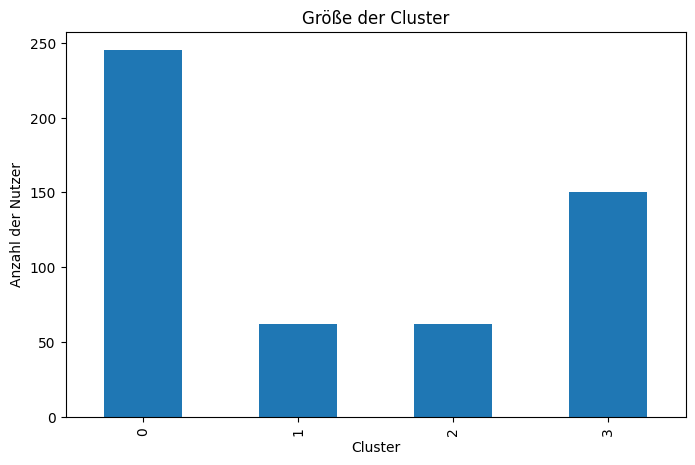

In [14]:
# Ensure all columns in X are converted to strings for KModes
X = X.astype(str)

# Convert the DataFrame to a NumPy array
X_matrix = X.to_numpy()

# k-Modes Clustering
k = 4
kmode = KModes(n_clusters=k, init='Cao', verbose=2, max_iter=50, n_init=3, random_state=42)
clusters = kmode.fit_predict(X_matrix)

# Store the cluster results in the DataFrame
df['cluster'] = clusters

print(f'Clusterzentren:\n{kmode.cluster_centroids_}')

print('Clustergrößen:')
print(pd.Series(clusters).value_counts())

# Display the most frequent value per cluster (mode)
print(df.groupby('cluster')[features].agg(lambda x: x.mode().iloc[0]))

# Plot the cluster sizes
plt.figure(figsize=(8, 5))
pd.Series(clusters).value_counts().sort_index().plot(kind='bar')
plt.title('Größe der Cluster')
plt.xlabel('Cluster')
plt.ylabel('Anzahl der Nutzer')
plt.show()


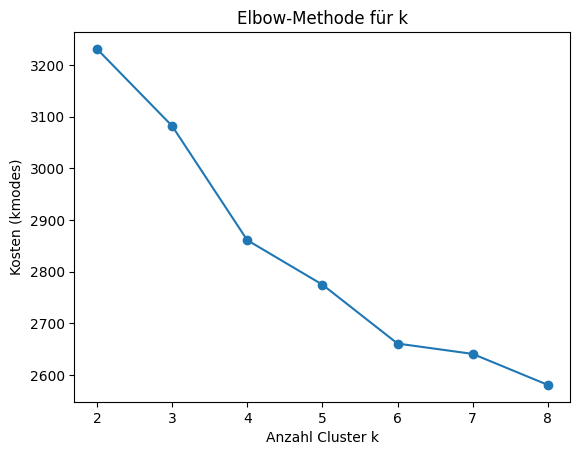

In [15]:
costs = []
K = range(2, 9)
for k in K:
    km = KModes(n_clusters=k, init='Cao', n_init=3, random_state=42)
    km.fit_predict(X)
    costs.append(km.cost_)

plt.plot(K, costs, marker='o')
plt.xlabel('Anzahl Cluster k')
plt.ylabel('Kosten (kmodes)')
plt.title('Elbow-Methode für k')
plt.show()


In [16]:
# Clusterprofiling nach Elbow-Analyse
def safe_mode(s):
    m = s.mode(dropna=False)
    return m.iloc[0] if len(m) else np.nan

def onehot_share(df_part, prefix, top=5):
    """Top-Anteile der aktivsten One-Hot-Features je Cluster."""
    cols = [c for c in df.columns if c.startswith(prefix + '_')]
    if not cols:
        return []
    shares = df_part[cols].apply(pd.to_numeric, errors='coerce').fillna(0).mean().sort_values(ascending=False)
    return [(c.replace(prefix + '_',''), round(float(v),3)) for c,v in shares.head(top).items() if v>0]

def profile_clusters(df_with_labels, cluster_col, simple_cat_cols, multi_choice_cols, target_col=None):
    profiles = []
    n = len(df_with_labels)
    for cl in sorted(df_with_labels[cluster_col].unique()):
        part = df_with_labels[df_with_labels[cluster_col]==cl]
        size = len(part)
        share = round(size/n,3)

        # Upgrade-Quote (falls Zielspalte existiert)
        yes_rate = None
        if target_col and target_col in part.columns:
            yes_rate = round((part[target_col]=="Yes").mean(),3)

        # Häufigste Kategorien (Modi)
        modes = {c: safe_mode(part[c]) for c in simple_cat_cols if c in part.columns}

        # Verteilung Abo-Plan
        plan_dist = None
        if "spotify_subscription_plan" in part.columns:
            plan_dist = (part["spotify_subscription_plan"].value_counts(normalize=True)
                         .round(3).to_dict())

        # Top Multi-Choice Features
        top_multi = {pref: onehot_share(part,pref,top=3) for pref in multi_choice_cols}

        profiles.append({
            "Cluster": cl,
            "Size": size,
            "Share": share,
            "Upgrade_YesRate": yes_rate,
            "Plan_Dist": plan_dist,
            "Modes": modes,
            "Top_Multi": top_multi
        })
    return profiles

# Kandidaten aus Elbow: k=3 und k=4 
candidates = [3,4]



all_profiles = {}
for k in candidates:
    km = KModes(n_clusters=k, init="Cao", n_init=3, random_state=42)
    labels = km.fit_predict(X)   # X = deine Feature-Matrix (bereits .astype(str).to_numpy())
    df[f"cluster_{k}"] = labels
    profs = profile_clusters(df, f"cluster_{k}",
                             simple_cat_cols=[
                                 "spotify_subscription_plan","fav_music_genre",
                                 "preffered_pod_duration","pod_host_preference",
                                 "preffered_premium_plan","music_lis_frequency"
                             ],
                             multi_choice_cols=["music_Influencial_mood","spotify_listening_device","music_expl_method"],
                             target_col="premium_sub_willingness")
    all_profiles[k] = profs

#  Ausgabe
for k, profs in all_profiles.items():
    print(f"\n===== Profile für k={k} =====")
    pprint.pprint(profs, width=120)



===== Profile für k=3 =====
[{'Cluster': np.uint16(0),
  'Modes': {'fav_music_genre': 'Melody',
            'music_lis_frequency': 'leisure time',
            'pod_host_preference': 'Both',
            'preffered_pod_duration': 'Shorter',
            'preffered_premium_plan': 'Unknown',
            'spotify_subscription_plan': 'Free (ad-supported)'},
  'Plan_Dist': {'Free (ad-supported)': 0.903, 'Premium (paid subscription)': 0.097},
  'Share': 0.674,
  'Size': 350,
  'Top_Multi': {'music_Influencial_mood': [('Relaxation and stress relief', 0.863),
                                           ('Uplifting and motivational', 0.26),
                                           ('Sadness or melancholy', 0.197)],
                'music_expl_method': [('recommendations', 0.597), ('Playlists', 0.543), ('Others', 0.203)],
                'spotify_listening_device': [('Smartphone', 0.951),
                                             ('Computer or laptop', 0.111),
                                 

Verwende Cluster-Spalte: cluster_3


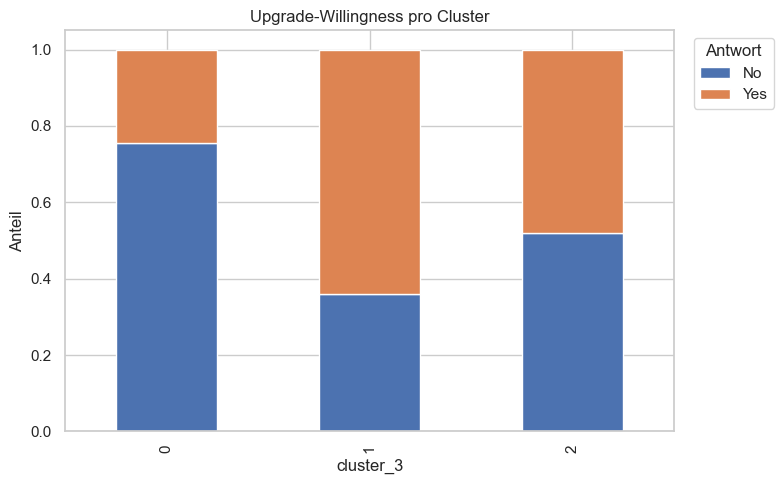

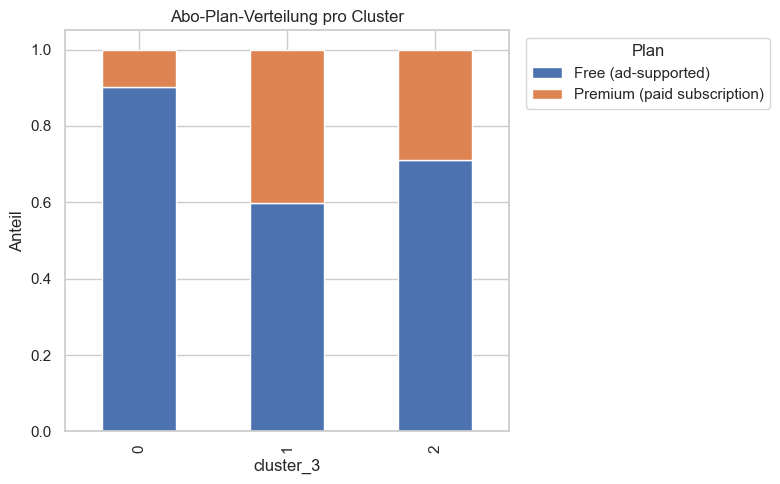

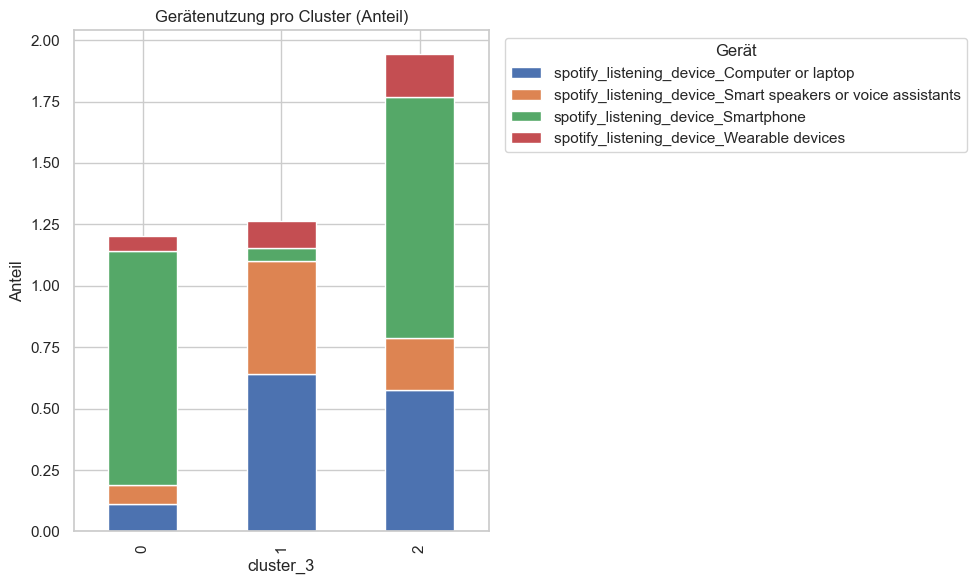

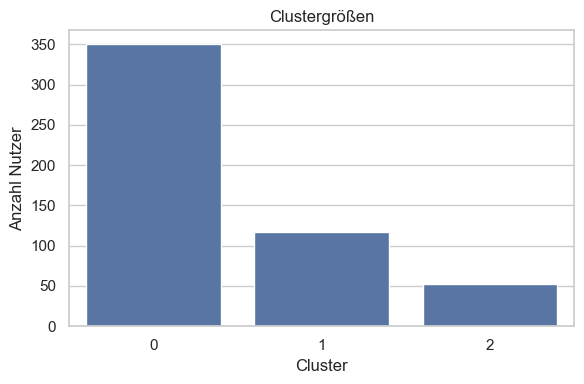

In [17]:
cluster_candidates = [c for c in df.columns if c.startswith("cluster_")]
if not cluster_candidates:
    raise ValueError("Keine Cluster-Spalte gefunden. Bitte zuerst Clustering laufen lassen (z.B. df['cluster_3']).")
# Bevorzuge cluster_3, dann cluster_4, sonst die erste gefundene
if "cluster_3" in cluster_candidates:
    cluster_col = "cluster_3"
elif "cluster_4" in cluster_candidates:
    cluster_col = "cluster_4"
else:
    cluster_col = cluster_candidates[0]

print(f"Verwende Cluster-Spalte: {cluster_col}")

# Einheitliche Plot-Optik
sns.set(style="whitegrid")

# Kleiner Helper zum sauberen Stacked-Plot mit Prozenten
def stacked_bar_percent(df_counts, title, ylabel="Anteil", figsize=(8,5), legend_title=None):
    ax = (df_counts.T / df_counts.sum(axis=1)).T.plot(kind="bar", stacked=True, figsize=figsize)
    plt.title(title)
    plt.ylabel(ylabel)
    if legend_title:
        ax.legend(title=legend_title, bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    plt.show()


# Upgrade-Willingness pro Cluster

if "premium_sub_willingness" in df.columns:
    upg = (
        df.groupby(cluster_col)["premium_sub_willingness"]
          .value_counts(dropna=False)
          .unstack(fill_value=0)
          .sort_index(axis=0)
    )
    if upg.shape[1] > 0:
        stacked_bar_percent(upg, "Upgrade-Willingness pro Cluster", legend_title="Antwort")
else:
    print("Hinweis: 'premium_sub_willingness' nicht vorhanden – Upgrade-Plot wird übersprungen.")


# Abo-Plan-Verteilung pro Cluster

if "spotify_subscription_plan" in df.columns:
    plans = (
        df.groupby(cluster_col)["spotify_subscription_plan"]
          .value_counts(dropna=False)
          .unstack(fill_value=0)
          .sort_index(axis=0)
    )
    if plans.shape[1] > 0:
        stacked_bar_percent(plans, "Abo-Plan-Verteilung pro Cluster", legend_title="Plan")
else:
    print("Hinweis: 'spotify_subscription_plan' nicht vorhanden – Plan-Plot wird übersprungen.")


# Gerätenutzung (Multi-Choice One-Hot) pro Cluster

device_prefix = "spotify_listening_device_"
device_cols = [c for c in df.columns if c.startswith(device_prefix)]

if device_cols:
    # Sicherstellen, dass Werte numerisch sind (0/1), falls sie als '0'/'1' Strings vorliegen
    device_shares = (
        df.groupby(cluster_col)[device_cols]
          .apply(lambda g: g.apply(pd.to_numeric, errors="coerce").fillna(0).mean())
    )
    # Stacked: je Cluster die Anteile der Geräte zeigen
    ax = device_shares.plot(kind="bar", stacked=True, figsize=(10,6))
    plt.title("Gerätenutzung pro Cluster (Anteil)")
    plt.ylabel("Anteil")
    plt.legend(title="Gerät", bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    print("Hinweis: Keine One-Hot-Geräte-Spalten gefunden (Prefix 'spotify_listening_device_').")


# Bonus) Clustergrößen

size_counts = df[cluster_col].value_counts().sort_index()
plt.figure(figsize=(6,4))
sns.barplot(x=size_counts.index.astype(str), y=size_counts.values)
plt.title("Clustergrößen")
plt.xlabel("Cluster")
plt.ylabel("Anzahl Nutzer")
plt.tight_layout()
plt.show()

# Evaluation

In [18]:



# Kompakte Persona-Profile 

def safe_mode(s):
    m = s.mode(dropna=False)
    return m.iloc[0] if len(m) else np.nan

simple_cat_cols = [
    "spotify_subscription_plan",
    "fav_music_genre",
    "preffered_pod_duration",
    "pod_host_preference",
    "preffered_premium_plan",
    "music_lis_frequency",
]

multi_choice_prefixes = ["music_Influencial_mood", "spotify_listening_device", "music_expl_method"]

def top_onehot_items(df_part, prefix, top=3):
    cols = [c for c in df.columns if c.startswith(prefix + "_")]
    if not cols:
        return []
    shares = df_part[cols].apply(pd.to_numeric, errors="coerce").fillna(0).mean().sort_values(ascending=False)
    return [c.replace(prefix + "_", "") for c in shares.head(top).index if shares.head(top)[c] > 0]

persona_lines = []
n = len(df)
for cl, part in df.groupby(cluster_col):
    share = len(part) / n
    # Upgrade-Yes-Rate
    yes_rate = None
    if "premium_sub_willingness" in part.columns:
        yes_rate = (part["premium_sub_willingness"] == "Yes").mean()

    # Häufigste Kategorien (leicht lesbar)
    modes = {c: safe_mode(part[c]) for c in simple_cat_cols if c in part.columns}
    # Top Multi-Choice-Items
    multi_tops = {p: top_onehot_items(part, p, top=3) for p in multi_choice_prefixes}

    line = f"Cluster {cl} (~{share:.0%} der Nutzer): "
    if modes.get("spotify_subscription_plan"):
        line += f"Plan: {modes['spotify_subscription_plan']}. "
    if yes_rate is not None:
        line += f"Upgrade-Bereitschaft (Yes): {yes_rate:.0%}. "
    if modes.get("fav_music_genre"):
        line += f"Top-Genre: {modes['fav_music_genre']}. "
    # füge 1–2 prägnante Multi-Choice-Highlights an
    highlights = []
    if multi_tops.get("spotify_listening_device"):
        highlights.append("Geräte: " + ", ".join(multi_tops["spotify_listening_device"]))
    if multi_tops.get("music_Influencial_mood"):
        highlights.append("Moods: " + ", ".join(multi_tops["music_Influencial_mood"]))
    if multi_tops.get("music_expl_method"):
        highlights.append("Entdeckung: " + ", ".join(multi_tops["music_expl_method"]))
    if highlights:
        line += " | " + " | ".join(hints for hints in highlights[:2])
    persona_lines.append(line)

print("\n--- Kompakte Persona-Beschreibungen ---")
for s in persona_lines:
    print("• " + s)


--- Kompakte Persona-Beschreibungen ---
• Cluster 0 (~67% der Nutzer): Plan: Free (ad-supported). Upgrade-Bereitschaft (Yes): 25%. Top-Genre: Melody.  | Geräte: Smartphone, Computer or laptop, Smart speakers or voice assistants | Moods: Relaxation and stress relief, Uplifting and motivational, Sadness or melancholy
• Cluster 1 (~23% der Nutzer): Plan: Free (ad-supported). Upgrade-Bereitschaft (Yes): 64%. Top-Genre: classical.  | Geräte: Computer or laptop, Smart speakers or voice assistants, Wearable devices | Moods: Uplifting and motivational, Sadness or melancholy, Relaxation and stress relief
• Cluster 2 (~10% der Nutzer): Plan: Free (ad-supported). Upgrade-Bereitschaft (Yes): 48%. Top-Genre: Pop.  | Geräte: Smartphone, Computer or laptop, Smart speakers or voice assistants | Moods: Relaxation and stress relief, Uplifting and motivational, Sadness or melancholy


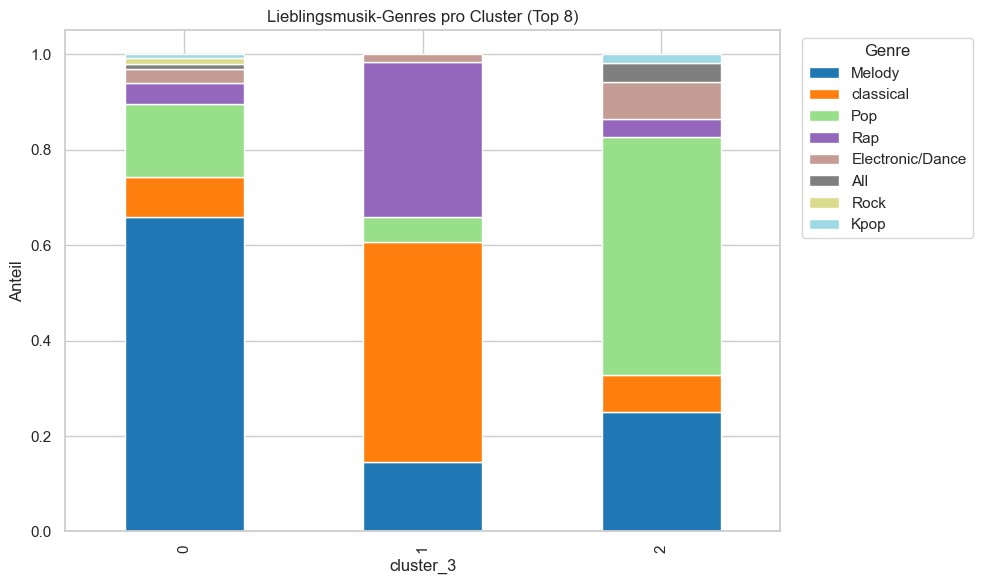

In [19]:
# Musikgenre-Verteilung pro Cluster
if "fav_music_genre" in df.columns:
    genre_counts = (
        df.groupby(cluster_col)["fav_music_genre"]
          .value_counts(dropna=False)
          .unstack(fill_value=0)
          .sort_index(axis=0)
    )

    # Top-N Genres (z. B. die häufigsten 8 insgesamt) auswählen
    top_genres = df["fav_music_genre"].value_counts().head(8).index
    genre_counts = genre_counts[top_genres]

    # Prozentualer Anteil pro Cluster
    genre_props = (genre_counts.T / genre_counts.sum(axis=1)).T

    ax = genre_props.plot(kind="bar", stacked=True, figsize=(10,6), colormap="tab20")
    plt.title("Lieblingsmusik-Genres pro Cluster (Top 8)")
    plt.ylabel("Anteil")
    plt.legend(title="Genre", bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    print("Hinweis: 'fav_music_genre' nicht im DataFrame gefunden.")


In [20]:
ct = pd.crosstab(df["cluster_4"], df["premium_sub_willingness"])
chi2, p, dof, exp = chi2_contingency(ct)
print("Chi²:", chi2, "p-Wert:", p)
print(ct)

Chi²: 56.2424196089738 p-Wert: 3.729164252672668e-12
premium_sub_willingness   No  Yes
cluster_4                        
0                        176   69
1                         20   42
2                         25   37
3                        112   38


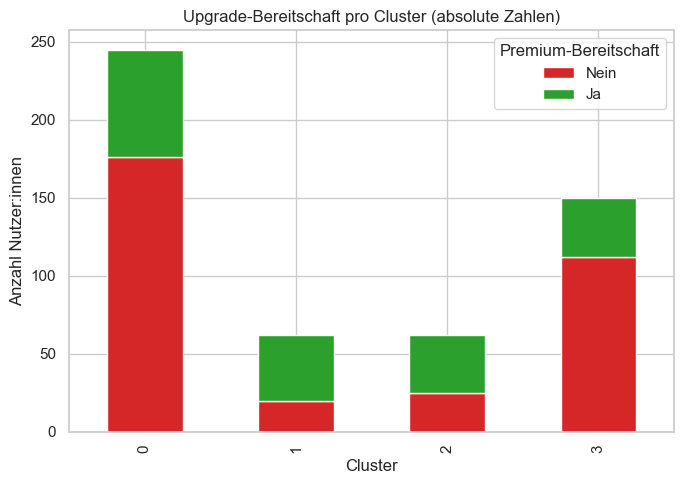

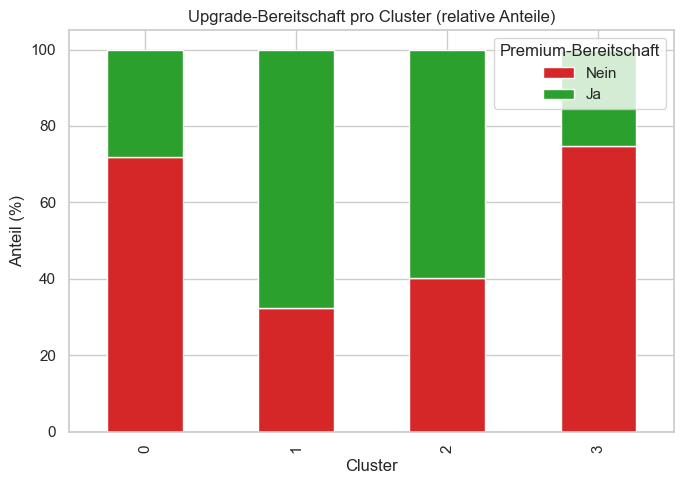

In [21]:
# Crosstab-Ergebnisse 
ct = pd.crosstab(df["cluster_4"], df["premium_sub_willingness"])

# Gestapeltes Balkendiagramm 
ct.plot(kind="bar", stacked=True, figsize=(7,5), color=["#d62728","#2ca02c"])
plt.title("Upgrade-Bereitschaft pro Cluster (absolute Zahlen)")
plt.xlabel("Cluster")
plt.ylabel("Anzahl Nutzer:innen")
plt.legend(title="Premium-Bereitschaft", labels=["Nein","Ja"])
plt.tight_layout()
plt.show()

# 100%-Balkendiagramm (relative Anteile)
(ct.div(ct.sum(axis=1), axis=0) * 100).plot(kind="bar", stacked=True, figsize=(7,5), color=["#d62728","#2ca02c"])
plt.title("Upgrade-Bereitschaft pro Cluster (relative Anteile)")
plt.xlabel("Cluster")
plt.ylabel("Anteil (%)")
plt.legend(title="Premium-Bereitschaft", labels=["Nein","Ja"])
plt.tight_layout()
plt.show()


In [23]:
ct = pd.crosstab(df["cluster_3"], df["premium_sub_willingness"])
chi2, p, dof, exp = chi2_contingency(ct)
print("Chi²:", chi2, "p-Wert:", p)
print(ct)

Chi²: 63.35720926704797 p-Wert: 1.7464526410250034e-14
premium_sub_willingness   No  Yes
cluster_3                        
0                        264   86
1                         42   75
2                         27   25


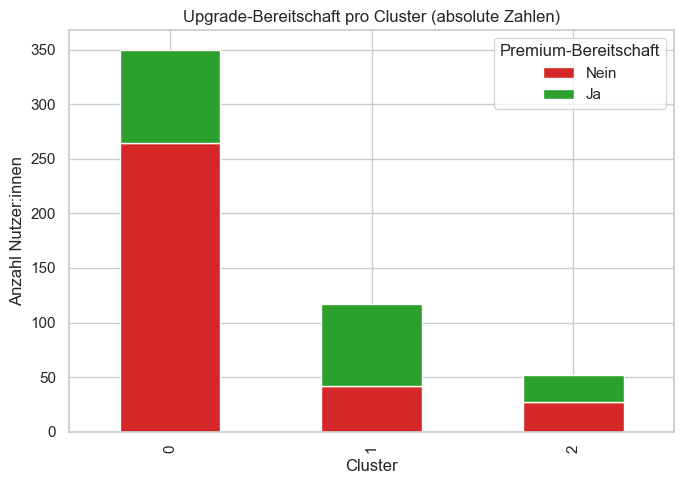

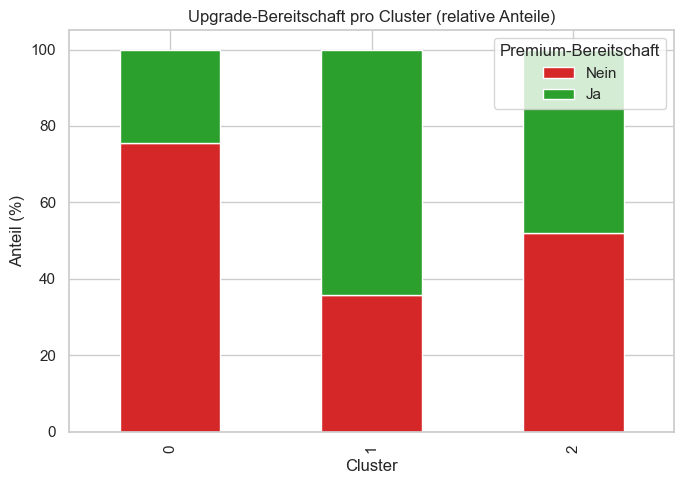

In [25]:
# Crosstab-Ergebnisse 
ct = pd.crosstab(df["cluster_3"], df["premium_sub_willingness"])

# Gestapeltes Balkendiagramm 
ct.plot(kind="bar", stacked=True, figsize=(7,5), color=["#d62728","#2ca02c"])
plt.title("Upgrade-Bereitschaft pro Cluster (absolute Zahlen)")
plt.xlabel("Cluster")
plt.ylabel("Anzahl Nutzer:innen")
plt.legend(title="Premium-Bereitschaft", labels=["Nein","Ja"])
plt.tight_layout()
plt.show()

# 100%-Balkendiagramm (relative Anteile)
(ct.div(ct.sum(axis=1), axis=0) * 100).plot(kind="bar", stacked=True, figsize=(7,5), color=["#d62728","#2ca02c"])
plt.title("Upgrade-Bereitschaft pro Cluster (relative Anteile)")
plt.xlabel("Cluster")
plt.ylabel("Anteil (%)")
plt.legend(title="Premium-Bereitschaft", labels=["Nein","Ja"])
plt.tight_layout()
plt.show()
